In [1]:
import os
os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda/lib64:' + os.environ.get('LD_LIBRARY_PATH', '')


In [2]:
import os
print("LD_LIBRARY_PATH:", os.environ.get('LD_LIBRARY_PATH'))


LD_LIBRARY_PATH: /usr/local/cuda/lib64:


In [3]:
import tensorflow as tf
print("GPUs detected:", tf.config.list_physical_devices('GPU'))


GPUs detected: []


In [4]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers, models #type: ignore
from tensorflow.keras.applications import ResNet50  #type: ignore
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator #type: ignore
from tensorflow.keras.utils import to_categorical #type: ignore
from tensorflow.keras.optimizers import Adam #type: ignore
from tensorflow.keras.optimizers.schedules import ExponentialDecay #type: ignore
from tensorflow.keras.regularizers import l2 #type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau #type: ignore
from tensorflow.keras.metrics import AUC, Precision, Recall #type: ignore

In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

class ImageDataset:
    def __init__(self, data_dir, max_images_per_class=2000):
        self.data_dir = data_dir
        self.max_images_per_class = max_images_per_class  
        self.images = []
        self.labels = []
        self.class_names = ['hojas', 'otros', 'animales'] 
        
    def load_data(self):
        """Carga datos con validación mejorada y límite de imágenes"""
        total_images = 0
        class_counts = {}
        
        for idx, label in enumerate(self.class_names):
            label_dir = os.path.join(self.data_dir, label)
            if not os.path.exists(label_dir):
                print(f"Advertencia: no existe la carpeta {label_dir}")
                continue
                
            class_count = 0
            for image_name in os.listdir(label_dir):
                if not image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    continue
                    
                img_path = os.path.join(label_dir, image_name)
                img_array = self.load_and_preprocess_image(img_path)
                if img_array is not None:
                    self.images.append(img_array)
                    self.labels.append(idx) 
                    class_count += 1
                    total_images += 1

                if class_count >= self.max_images_per_class:
                    print(f"Clase '{label}': Se han cargado el máximo de {self.max_images_per_class} imágenes.")
                    break
            
            class_counts[label] = class_count
            print(f"Clase '{label}': {class_count} imágenes")
        
        print(f"Total de imágenes cargadas: {total_images}")
        
        if class_counts:
            max_count = max(class_counts.values())
            min_count = min(class_counts.values())
            ratio = max_count / min_count if min_count > 0 else float('inf')
            
            if ratio > 3:
                print(f"Desbalance detectado: ratio {ratio:.2f}:1")
                print("Considera usar class_weight o data augmentation")
        
        return class_counts

    def load_and_preprocess_image(self, img_path):
        """Carga y preprocesa imagen con manejo de errores mejorado"""
        try:
            img = load_img(img_path, target_size=(224, 224))
            img_array = img_to_array(img) / 255.0
            return img_array
        except Exception as e:
            print(f"Error al cargar {img_path}: {e}")
            return None


In [7]:
print("Clasificador de Hojas")
print("=" * 50)

data_dir = 'data/'
dataset = ImageDataset(data_dir)
class_counts = dataset.load_data()

if not dataset.images:
    print("No se cargaron imágenes. Verifica la estructura de carpetas.")
    exit(1)

Clasificador de Hojas
Clase 'hojas': Se han cargado el máximo de 2000 imágenes.
Clase 'hojas': 2000 imágenes
Clase 'otros': Se han cargado el máximo de 2000 imágenes.
Clase 'otros': 2000 imágenes
Clase 'animales': Se han cargado el máximo de 2000 imágenes.
Clase 'animales': 2000 imágenes
Total de imágenes cargadas: 6000


In [8]:
images = np.array(dataset.images)
labels = np.array(dataset.labels)
labels_cat = to_categorical(labels, num_classes=3)

print(f"\nDatos preparados:")
print(f"Imágenes: {images.shape}")
print(f"Etiquetas: {labels_cat.shape}")


Datos preparados:
Imágenes: (6000, 224, 224, 3)
Etiquetas: (6000, 3)


In [9]:
X_train, X_val, y_train, y_val = train_test_split(
        images, labels_cat, 
        test_size=0.2, 
        random_state=42, 
        stratify=labels
    )

print(f"\nDivisión de datos:")
print(f"Entrenamiento: {X_train.shape[0]} imágenes")
print(f"Validación: {X_val.shape[0]} imágenes")


División de datos:
Entrenamiento: 4800 imágenes
Validación: 1200 imágenes


In [10]:
def mostrar_ejemplos(imagenes, labels, num_ejemplos=3):
    """
    Muestra ejemplos de imágenes para cada clase.
    """
    print("\n Ejemplos de Imágenes por Clase")
    print("=" * 50)
    
    clases_unicas = np.unique(labels)
    n_clases = len(clases_unicas)
    fig, axes = plt.subplots(n_clases, num_ejemplos, figsize=(num_ejemplos*3, n_clases*3))
    
    if n_clases == 1:
        axes = np.array([axes])
    

    for idx_clase, clase in enumerate(clases_unicas):
        imagenes_clase = imagenes[labels == clase]
        indices = np.random.choice(len(imagenes_clase), num_ejemplos, replace=False)
        
        for idx_ejemplo in range(num_ejemplos):
            img_idx = indices[idx_ejemplo]
            img = imagenes_clase[img_idx]
            
            if len(img.shape) == 3 and img.shape[2] == 3:
                axes[idx_clase, idx_ejemplo].imshow(img)
            else:
                axes[idx_clase, idx_ejemplo].imshow(img, cmap='gray')
                
            axes[idx_clase, idx_ejemplo].set_title(f'Clase {clase}')
            axes[idx_clase, idx_ejemplo].axis('off')
    
    plt.tight_layout()
    plt.show()



 Ejemplos de Imágenes por Clase


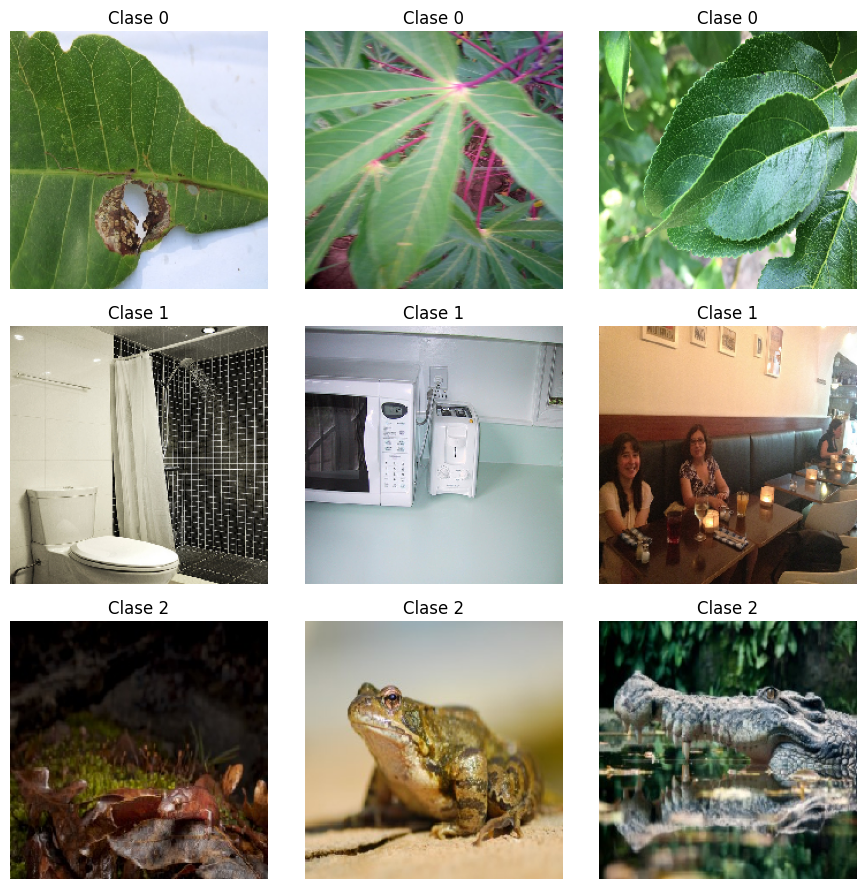

In [11]:
mostrar_ejemplos(images, labels)

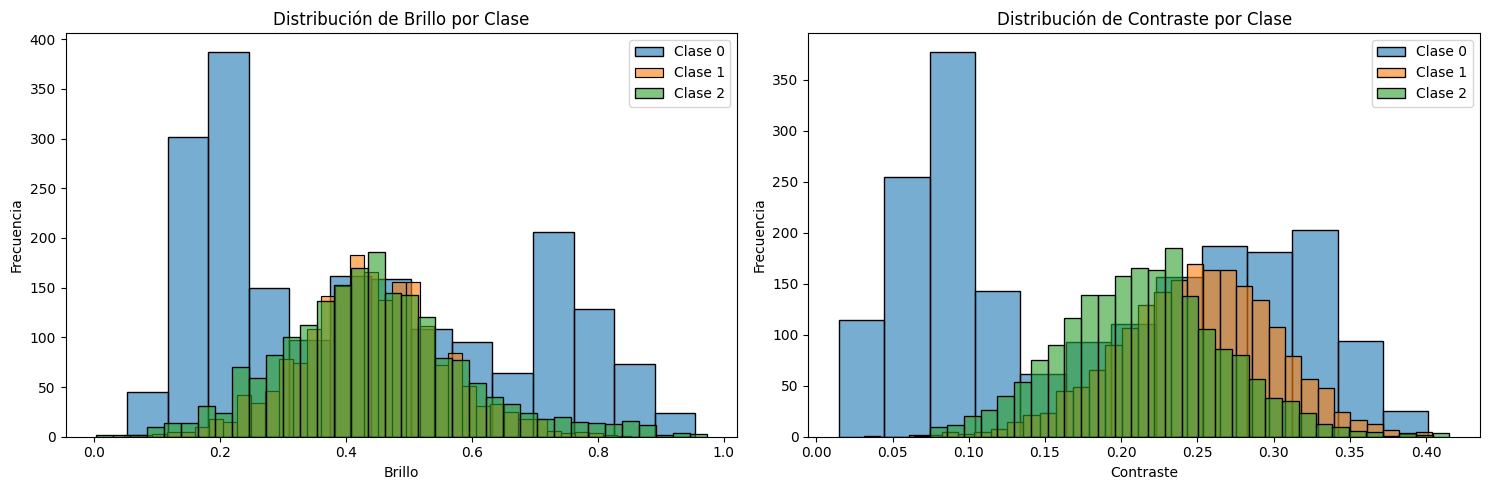

In [13]:
def analizar_distribuciones(imagenes, labels):
    plt.figure(figsize=(15, 5))
    
    # Crear subplots para brillo y contraste
    plt.subplot(1, 2, 1)
    for clase in np.unique(labels):
        imagenes_clase = imagenes[labels == clase]
        brilleras = [np.mean(img) for img in imagenes_clase]
        sns.histplot(brilleras, label=f'Clase {clase}', alpha=0.6)
    plt.title('Distribución de Brillo por Clase')
    plt.xlabel('Brillo')
    plt.ylabel('Frecuencia')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    for clase in np.unique(labels):
        imagenes_clase = imagenes[labels == clase]
        contrastes = [np.std(img) for img in imagenes_clase]
        sns.histplot(contrastes, label=f'Clase {clase}', alpha=0.6)
    plt.title('Distribución de Contraste por Clase')
    plt.xlabel('Contraste')
    plt.ylabel('Frecuencia')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

analizar_distribuciones(images, labels)

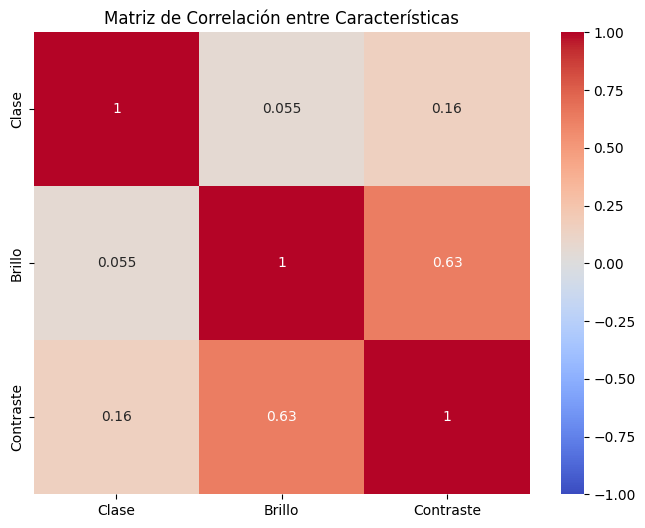

In [ ]:
import pandas as pd

def analizar_correlaciones(imagenes, labels):

    datos = []
    for img, label in zip(imagenes, labels):
        brillo = np.mean(img)
        contraste = np.std(img)
        datos.append([label, brillo, contraste])
    
    df = pd.DataFrame(datos, columns=['Clase', 'Brillo', 'Contraste'])
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Matriz de Correlación entre Características')
    plt.show()

analizar_correlaciones(images, labels)

/tmp/ipykernel_11166/867895848.py:10: UserWarning: 

`shade_lowest` has been replaced by `thresh`; setting `thresh=0.05.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data={'Brillo': brilleras, 'Contraste': contrastes},
/tmp/ipykernel_11166/867895848.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data={'Brillo': brilleras, 'Contraste': contrastes},
/tmp/ipykernel_11166/867895848.py:10: UserWarning: 

`shade_lowest` has been replaced by `thresh`; setting `thresh=0.05.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data={'Brillo': brilleras, 'Contraste': contrastes},
/tmp/ipykernel_11166/867895848.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data={'Bril

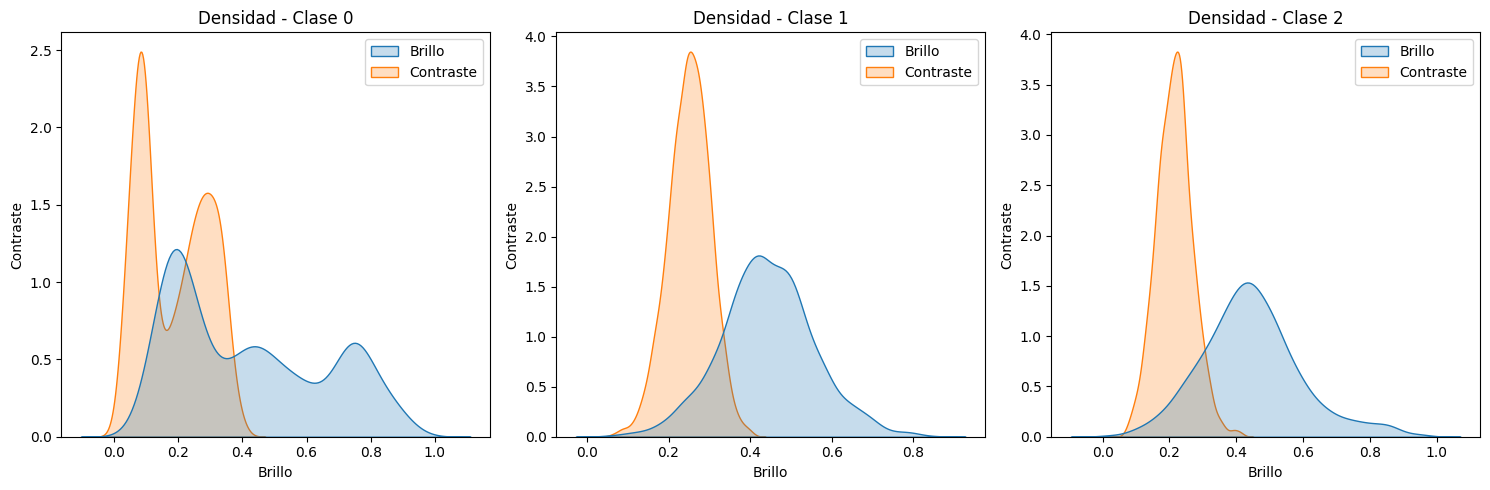

In [15]:
def analizar_densidad(imagenes, labels):
    plt.figure(figsize=(15, 5))
    
    for idx, clase in enumerate(np.unique(labels)):
        imagenes_clase = imagenes[labels == clase]
        brilleras = [np.mean(img) for img in imagenes_clase]
        contrastes = [np.std(img) for img in imagenes_clase]
        
        plt.subplot(1, 3, idx + 1)
        sns.kdeplot(data={'Brillo': brilleras, 'Contraste': contrastes}, 
                   shade=True, shade_lowest=False)
        plt.title(f'Densidad - Clase {clase}')
        plt.xlabel('Brillo')
        plt.ylabel('Contraste')
    
    plt.tight_layout()
    plt.show()

analizar_densidad(images, labels)

In [10]:
# Importaciones necesarias
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau,
    ModelCheckpoint, TensorBoard
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import (
    Precision, Recall, AUC, F1Score
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)

In [ ]:
def modelo_base():
    """
    Crea y configura el modelo convolucional para clasificación de hojas.
    """
    model = Sequential([

        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)), # Sale (112, 112, 32)
        
  
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)), # Sale (56, 56, 64)
        

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)), # Sale (28, 28, 128)
        
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)), # Sale (14, 14, 256)
        

        Flatten(),
        
        Dense(256, activation='relu'), 
        BatchNormalization(),
        
        Dropout(0.3), 
        
        Dense(3, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            Precision(),
            Recall(),
            AUC()
        ]
    )
    
    return model

modelo = modelo_base()

/home/juan0/Backend-Tesis/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1749508922.659938    5121 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5578 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [ ]:
def configurar_callbacks():
    """
    Configura los callbacks para el entrenamiento.
    """
    callbacks = [
        EarlyStopping(
            patience=5,
            min_delta=0.001,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6
        ),
        ModelCheckpoint(
            filepath='mejor_modelo.h5',
            monitor='val_loss',
            save_best_only=True,
            mode='min'
        )
    ]
    
    return callbacks

callbacks = configurar_callbacks()

In [ ]:
def entrenar_modelo(modelo, X_train, y_train, X_val, y_val, callbacks, epochs, batch_size):
    """
    Entrena el modelo con los generadores y callbacks configurados.
    """
    history = modelo.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        callbacks=callbacks,
        batch_size=batch_size,
        verbose=1
    )
    
    return history


In [16]:
history = entrenar_modelo(modelo, X_train, y_train, X_val, y_val, callbacks, epochs=10, batch_size=32)

Epoch 1/10


I0000 00:00:1749508976.501327    5669 service.cc:152] XLA service 0x733d8c02d350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749508976.501854    5669 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-06-09 17:42:56.611190: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749508979.916613    5669 cuda_dnn.cc:529] Loaded cuDNN version 91001


  1/150 ━━━━━━━━━━━━━━━━━━━━ 39:56 16s/step - accuracy: 0.3125 - auc: 0.4343 - loss: 2.4059 - precision: 0.3214 - recall: 0.2812

I0000 00:00:1749508989.948270    5669 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7161 - auc: 0.8769 - loss: 0.8685 - precision: 0.7252 - recall: 0.7045

150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 102ms/step - accuracy: 0.7166 - auc: 0.8772 - loss: 0.8669 - precision: 0.7256 - recall: 0.7049 - val_accuracy: 0.3333 - val_auc: 0.6040 - val_loss: 2.2986 - val_precision: 0.3333 - val_recall: 0.3333 - learning_rate: 1.0000e-04
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8868 - auc: 0.9742 - loss: 0.3073 - precision: 0.8873 - recall: 0.8802

150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.8868 - auc: 0.9742 - loss: 0.3073 - precision: 0.8873 - recall: 0.8802 - val_accuracy: 0.6442 - val_auc: 0.8198 - val_loss: 0.8404 - val_precision: 0.6881 - val_recall: 0.5975 - learning_rate: 1.0000e-04
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9228 - auc: 0.9876 - loss: 0.2071 - precision: 0.9245 - recall: 0.9168

150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.9228 - auc: 0.9876 - loss: 0.2070 - precision: 0.9245 - recall: 0.9169 - val_accuracy: 0.8375 - val_auc: 0.9556 - val_loss: 0.3974 - val_precision: 0.8430 - val_recall: 0.8275 - learning_rate: 1.0000e-04
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9564 - auc: 0.9956 - loss: 0.1205 - precision: 0.9590 - recall: 0.9554

150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.9564 - auc: 0.9956 - loss: 0.1205 - precision: 0.9590 - recall: 0.9554 - val_accuracy: 0.8883 - val_auc: 0.9723 - val_loss: 0.3173 - val_precision: 0.8929 - val_recall: 0.8825 - learning_rate: 1.0000e-04
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.9665 - auc: 0.9968 - loss: 0.0953 - precision: 0.9686 - recall: 0.9648 - val_accuracy: 0.8167 - val_auc: 0.9247 - val_loss: 0.6472 - val_precision: 0.8173 - val_recall: 0.8167 - learning_rate: 1.0000e-04
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9569 - auc: 0.9961 - loss: 0.1119 - precision: 0.9592 - recall: 0.9551

150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.9570 - auc: 0.9961 - loss: 0.1118 - precision: 0.9592 - recall: 0.9551 - val_accuracy: 0.9100 - val_auc: 0.9841 - val_loss: 0.2738 - val_precision: 0.9130 - val_recall: 0.9092 - learning_rate: 1.0000e-04
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.9743 - auc: 0.9976 - loss: 0.0869 - precision: 0.9745 - recall: 0.9736 - val_accuracy: 0.8800 - val_auc: 0.9651 - val_loss: 0.4158 - val_precision: 0.8855 - val_recall: 0.8767 - learning_rate: 1.0000e-04
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9797 - auc: 0.9990 - loss: 0.0589 - precision: 0.9803 - recall: 0.9785

150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.9797 - auc: 0.9990 - loss: 0.0589 - precision: 0.9803 - recall: 0.9785 - val_accuracy: 0.9450 - val_auc: 0.9889 - val_loss: 0.1815 - val_precision: 0.9466 - val_recall: 0.9450 - learning_rate: 1.0000e-04
Epoch 9/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - accuracy: 0.9860 - auc: 0.9988 - loss: 0.0459 - precision: 0.9860 - recall: 0.9848 - val_accuracy: 0.9425 - val_auc: 0.9883 - val_loss: 0.2063 - val_precision: 0.9439 - val_recall: 0.9392 - learning_rate: 1.0000e-04
Epoch 10/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.9941 - auc: 0.9999 - loss: 0.0188 - precision: 0.9941 - recall: 0.9941 - val_accuracy: 0.9467 - val_auc: 0.9887 - val_loss: 0.2023 - val_precision: 0.9473 - val_recall: 0.9442 - learning_rate: 1.0000e-04


In [ ]:
def evaluar_modelo(modelo, X_val, y_val):
    """
    Evalúa el modelo con métricas detalladas.
    """
    y_pred = modelo.predict(X_val)
    y_pred_class = np.argmax(y_pred, axis=1)
    y_true_class = np.argmax(y_val, axis=1)
    

    metrics = {}
    for i in range(3):
        y_pred_i = (y_pred_class == i)
        y_true_i = (y_true_class == i)
        
        metrics[f'clase_{i}'] = {
            'precision': precision_score(y_true_i, y_pred_i),
            'recall': recall_score(y_true_i, y_pred_i),
            'f1': f1_score(y_true_i, y_pred_i),
            'auc': roc_auc_score(y_true_i, y_pred_i)
        }
    
    metrics['general'] = {
        'accuracy': accuracy_score(y_true_class, y_pred_class),
        'macro_f1': f1_score(y_true_class, y_pred_class, average='macro'),
        'macro_precision': precision_score(y_true_class, y_pred_class, average='macro'),
        'macro_recall': recall_score(y_true_class, y_pred_class, average='macro')
    }
    
    return metrics

metrics = evaluar_modelo(modelo, X_val, y_val)

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


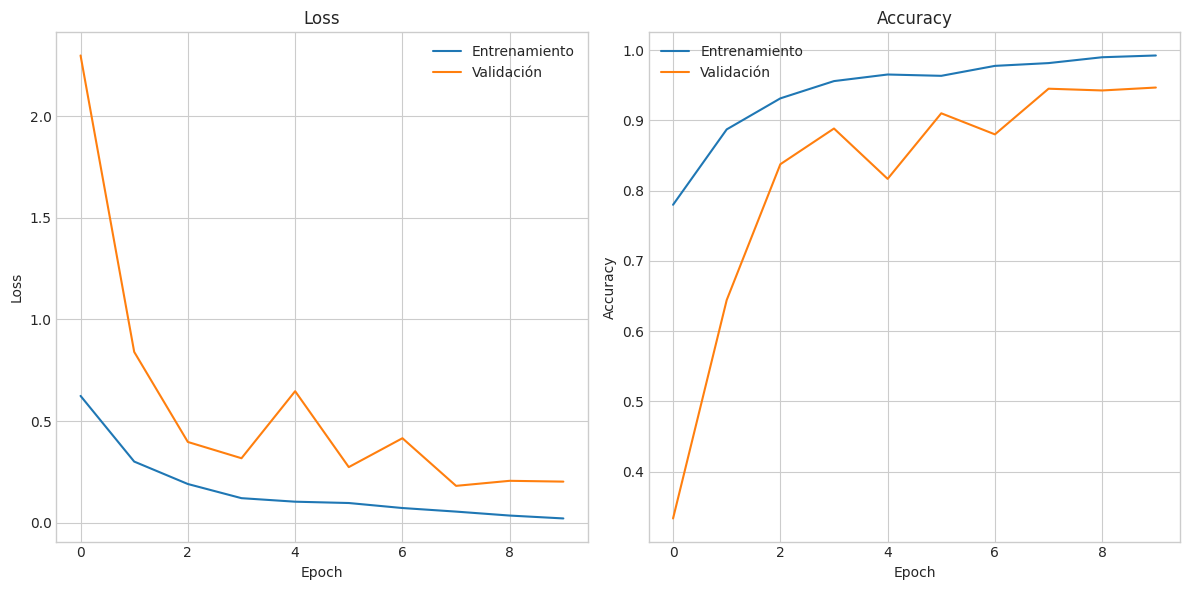

In [ ]:

def visualizar_resultados(history):
    """
    Visualiza las métricas de entrenamiento.
    """

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams['figure.figsize'] = [12, 6]
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

visualizar_resultados(history)

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


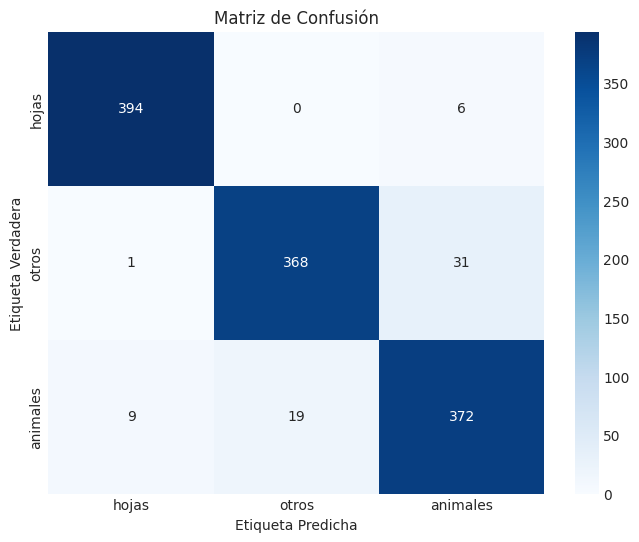

In [19]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_probs = modelo.predict(X_val)


y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_true, y_pred)

# Etiquetas de las clases
class_names = ['hojas', 'otros', 'animales']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


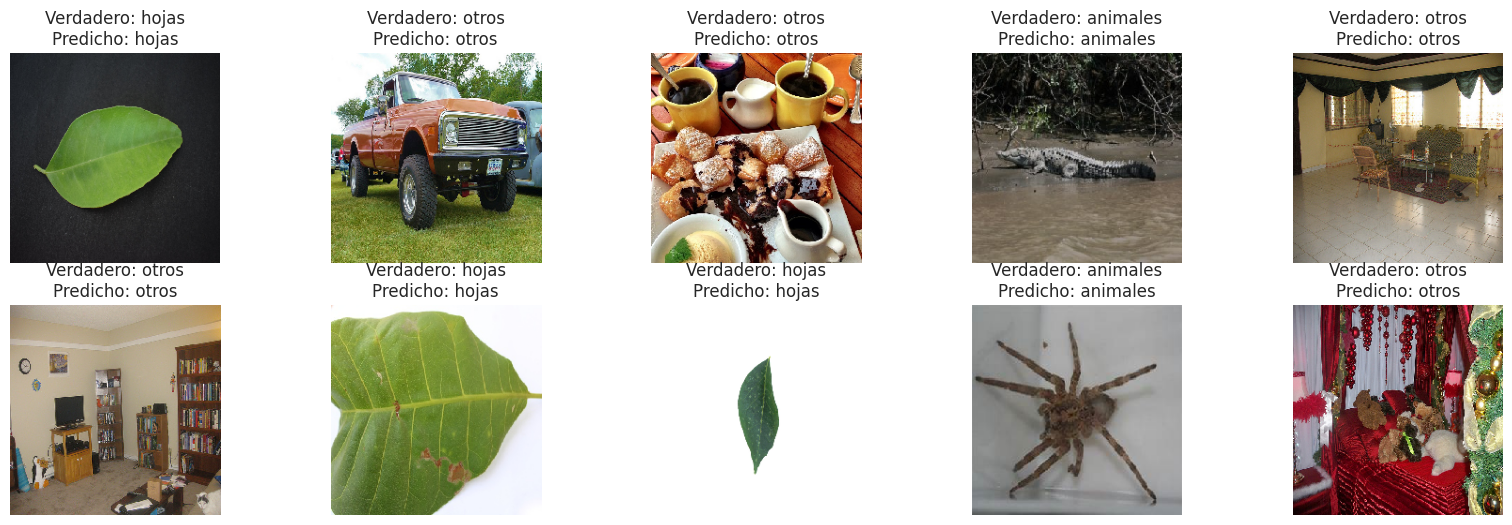

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np


indices = random.sample(range(len(X_val)), 10)
class_names = ['hojas', 'otros', 'animales']

plt.figure(figsize=(20, 6))

for i, idx in enumerate(indices):
    img = X_val[idx]
    true_label = np.argmax(y_val[idx])
    
    img_input = np.expand_dims(img, axis=0)
    pred_probs = modelo.predict(img_input)
    pred_label = np.argmax(pred_probs[0])
    
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Verdadero: {class_names[true_label]}\nPredicho: {class_names[pred_label]}")
    
plt.show()




In [1]:
modelo.save("modelo_hojas_multiclasev2.h5")

NameError: name 'modelo' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


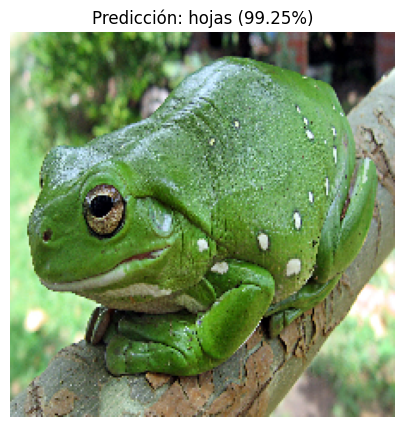

Shape de la imagen procesada: (224, 224, 3)
Predicción cruda (probabilidades): [9.9246794e-01 7.2133034e-03 3.1869530e-04]
Predicción final: hojas con probabilidad 0.9925


In [ ]:
from tensorflow.keras.models import load_model #type: ignore
from tensorflow.keras.preprocessing import image #type: ignore

modelo_cargado = load_model('modelo_hojas_multiclasev2.h5')
img_path = 'tests/frog.jpg'
clases = ['hojas', 'otros', 'animales']

img = image.load_img(img_path, target_size=(224, 224))

img_array = image.img_to_array(img)

img_array_expanded = np.expand_dims(img_array, axis=0) / 255.0

prediccion = modelo_cargado.predict(img_array_expanded)

indice_clase = np.argmax(prediccion[0])

etiqueta_predicha = clases[indice_clase]
probabilidad = prediccion[0][indice_clase]

plt.figure(figsize=(5,5))
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicción: {etiqueta_predicha} ({probabilidad:.2%})")
plt.show()

print(f"Shape de la imagen procesada: {img_array.shape}")
print(f"Predicción cruda (probabilidades): {prediccion[0]}")
print(f"Predicción final: {etiqueta_predicha} con probabilidad {probabilidad:.4f}")